In [ ]:
from ast import increment_lineno
# Libraries imports

## Standard Libraries
import os
import numpy as np
import math
import json
from functools import partial
from itertools import repeat
from PIL import Image
from collections import defaultdict
from typing import Any

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

##tqdm for progress bars
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random
from jax import dtypes

main_rng = jax.random.PRNGKey(42)

## Flax
import flax.linen as nn
from flax.training import train_state, checkpoints

## Optax
import optax

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

CHECKPOINT_PATH = './checkpoints'

# Import tensorboard
%load_ext tensorboard

<ipython-input-1-ecda9c486108>:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [ ]:
### Data Preprocessing functions

# Image transformation
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])

def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255 - DATA_MEANS) / DATA_STD
    return img

# Stacking the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for  samples in transposed]
    else:
        return np.array(batch)

test_transform = image_to_numpy
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1,1)),
    image_to_numpy
])

In [ ]:
### Download and load the dataset and prepare the dataloaders

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
val_dataset = CIFAR10(root='./data', train=True, download=True, transform=test_transform)

train_set, _  = data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

test_set = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = data.DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    collate_fn=numpy_collate,
    num_workers=8,
    persistent_workers=True
)
val_loader = data.DataLoader(
    val_set,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    collate_fn=numpy_collate,
    num_workers=4,
    persistent_workers=True
)
test_loader = data.DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    collate_fn=numpy_collate,
    num_workers=4,
    persistent_workers=True
)

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


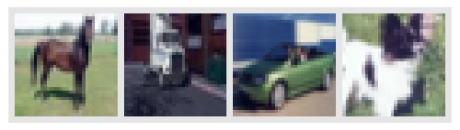

In [ ]:
# Visualize some examples

def numpy_to_torch(array):
    array = jax.device_get(array)
    tensor = torch.from_numpy(array)
    tensor = tensor.permute(0, 3, 1, 2)
    return tensor

NUM_IMAGES = 4
CIFAR_images = np.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], axis=0)
img_grid = torchvision.utils.make_grid(numpy_to_torch(CIFAR_images),
                                       nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
def patchify(x, patch_size, flatten_channels=True):
    """ Convert the image to patches """
    # Proceed with patchifying
    B, H, W, C = x.shape
    x = x.reshape(B, H//patch_size, patch_size, W//patch_size, patch_size, C)
    x = x.transpose(0, 1, 3, 2, 4, 5)    # [B, H', W', p_H, p_W, C]
    x = x.reshape(B, -1, *x.shape[3:])   # [B, H'*W', p_H, p_W, C]
    if flatten_channels:
        x = x.reshape(B, x.shape[1], -1) # [B, H'*W', p_H*p_W*C]
    return x


def unpatchify(x, patch_size, original_shape):
    """ Convert patches back to the original image.

    Args:
        x (jnp.ndarray): Patches array of shape [B, H'*W', p_H*p_W*C] or [B, H'*W', p_H, p_W, C].
        patch_size (int): Size of each patch (assumed square patches for simplicity).
        original_shape (tuple): Original image shape (B, H, W, C).

    Returns:
        jnp.ndarray: Reconstructed image of shape [B, H, W, C].
    """
    B, H, W, C = original_shape
    H_patches = H // patch_size
    W_patches = W // patch_size

    # If flattened, reshape back to patches
    if x.ndim == 3:  # [B, H'*W', p_H*p_W*C]
        x = x.reshape(B, H_patches * W_patches, patch_size, patch_size, C)

    # Rearrange into grid structure
    x = x.reshape(B, H_patches, W_patches, patch_size, patch_size, C)
    x = x.transpose(0, 1, 3, 2, 4, 5)  # [B, H', p_H, W', p_W, C]

    # Merge patches to reconstruct the image
    x = x.reshape(B, H, W, C)  # [B, H, W, C]
    return x


def unbatched_gather(x, ids_keep):
    return x[ids_keep, Ellipsis]


batched_gather = jax.vmap(unbatched_gather)


def random_masking(x, rng, mask_ratio=0.75):

    N, L, D = x.shape # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))

    noise = jax.random.uniform(rng, (N, L))

    # sort noise for each sample
    ids_shuffle = jnp.argsort(noise, axis=1)  # ascend: small is keep, large is remove
    ids_restore = jnp.argsort(ids_shuffle, axis=1)

    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = batched_gather(x, ids_keep)

    # generate the binary mask: 0 is keep, 1 is remove
    mask = jnp.ones((N, L))
    mask = mask.at[:, :len_keep].set(0)

    mask = batched_gather(mask, ids_restore)
    return x_masked, mask, ids_restore

### Functions for patchification and masking

def patchify(x, patch_size, flatten_channels=True):
    """
    Convert the image to patches
    """

    # Proceed with patchifying
    B, H, W, C = x.shape
    x = x.reshape(B, H//patch_size, patch_size, W//patch_size, patch_size, C)
    x = x.transpose(0, 1, 3, 2, 4, 5)    # [B, H', W', p_H, p_W, C]
    x = x.reshape(B, -1, *x.shape[3:])   # [B, H'*W', p_H, p_W, C]
    if flatten_channels:
        x = x.reshape(B, x.shape[1], -1) # [B, H'*W', p_H*p_W*C]
    return x


def unpatchify(x, patch_size, original_shape):
    """
    Convert patches back to the original image.

    Args:
        x (jnp.ndarray): Patches array of shape [B, H'*W', p_H*p_W*C] or [B, H'*W', p_H, p_W, C].
        patch_size (int): Size of each patch (assumed square patches for simplicity).
        original_shape (tuple): Original image shape (B, H, W, C).

    Returns:
        jnp.ndarray: Reconstructed image of shape [B, H, W, C].
    """
    B, H, W, C = original_shape
    H_patches = H // patch_size
    W_patches = W // patch_size

    # If flattened, reshape back to patches
    if x.ndim == 3:  # [B, H'*W', p_H*p_W*C]
        x = x.reshape(B, H_patches * W_patches, patch_size, patch_size, C)

    # Rearrange into grid structure
    x = x.reshape(B, H_patches, W_patches, patch_size, patch_size, C)
    x = x.transpose(0, 1, 3, 2, 4, 5)  # [B, H', p_H, W', p_W, C]

    # Merge patches to reconstruct the image
    x = x.reshape(B, H, W, C)  # [B, H, W, C]
    return x


def unbatched_gather(x, ids_keep):
    return x[ids_keep, Ellipsis]

batched_gather = jax.vmap(unbatched_gather)

def random_masking(x, rng,  mask_ratio=0.75):
    N, L, D = x.shape  # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))

    noise = jax.random.uniform(rng, (N, L))

    # sort noise for each sample
    ids_shuffle = jnp.argsort(noise, axis=1)  # ascend: small is keep, large is remove
    ids_restore = jnp.argsort(ids_shuffle, axis=1)

    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = batched_gather(x, ids_keep)

    # generate the binary mask: 0 is keep, 1 is remove
    mask = jnp.ones((N, L))
    mask = mask.at[:, :len_keep].set(0)

    mask = batched_gather(mask, ids_restore)
    return x_masked, mask, ids_restore

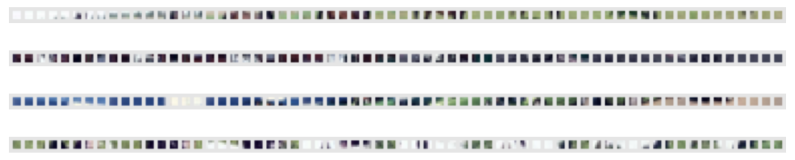

In [ ]:
# Visualization of patches
img_patches = patchify(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14, 3))
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(numpy_to_torch(img_patches[i]),
                                           nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

In [ ]:
# Test for the unpatchification method and masking (returned all the patches for that time)

flat_patches = patchify(CIFAR_images, patch_size=4, flatten_channels=True)
masked_pacthes, _ = random_masking(flat_patches, jax.random.PRNGKey(42))
unpatched = unpatchify(masked_pacthes, patch_size=4, original_shape=CIFAR_images.shape)
img_grid = torchvision.utils.make_grid(numpy_to_torch(unpatched),
                                        nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()


ValueError: too many values to unpack (expected 2)

In [ ]:
### Vision Transformer as the Encoder and Decoder implementation

class AttentionBlock(nn.Module):
    embed_dim: int
    hidden_dim: int
    num_heads: int
    dropout_prob: float = 0.0

    def setup(self):
        self.attn = nn.MultiHeadDotProductAttention(num_heads=self.num_heads)
        self.linear = [
            nn.Dense(self.hidden_dim),
            nn.gelu,
            nn.Dropout(self.dropout_prob),
            nn.Dense(self.embed_dim),
        ]
        self.layer_norm_1 = nn.LayerNorm()
        self.layer_norm_2 = nn.LayerNorm()
        self.dropout = nn.Dropout(self.dropout_prob)

    def __call__(self, x, train: bool = True):
        inp_x = self.layer_norm_1(x)
        attn_out = self.attn(inputs_q=inp_x, inputs_kv=inp_x)
        x = x + self.dropout(attn_out, deterministic=not train)

        linear_out = self.layer_norm_2(x)
        for layer in self.linear:
            linear_out = layer(linear_out) if not isinstance(layer, nn.Dropout) else layer(linear_out, deterministic=not train)
        x = x + self.dropout(linear_out, deterministic=not train)
        return x


class ViTEncoder(nn.Module):
    embed_dim: int
    hidden_dim: int
    num_heads: int
    num_layers: int
    patch_size: int
    num_patches: int
    num_channels: int = 3
    dropout_prob: float = 0.0

    def setup(self):
        # Layers/Networks
        self.input_layer = nn.Dense(self.embed_dim)
        self.transformer = [AttentionBlock(self.embed_dim,
                                           self.hidden_dim,
                                           self.num_heads,
                                           self.dropout_prob) for _ in range(self.num_layers)]


        ## Since this Transformer will only perform encoding, a classification head as well as classification
        ## tokens are not necessary in this case

        self.dropout = nn.Dropout(self.dropout_prob)

        ## Parameters/Embeddings

        self.pos_embedding = self.param('pos_embedding',
                                        nn.initializers.normal(stddev=0.02),
                                        (1, 1+self.num_patches, self.embed_dim))

        self.cls_token = self.param('cls_token',
                               nn.initializers.normal(stddev=0.02),
                               (1, 1, self.embed_dim))

    def __call__(self, x, train:bool = True):
        # Patchify and embed the input
        x = patchify(x, self.patch_size)
        x = self.input_layer(x)

        # Mask input patches
        rng = self.make_rng('random_masking')
        x, mask, ids_restore = random_masking(x, rng=rng)

        # Add positional encoding and append CLS token
        cls_token = self.cls_token.repeat(x.shape[0], axis=0)
        x = jnp.concatenate([cls_token, x], axis=1)
        x = x + self.pos_embedding[:, :x.shape[1]]

        # Apply Transformer
        x = self.dropout(x, deterministic=not train)
        for block in self.transformer:
            x = block(x, train=train)

        return x, mask, ids_restore


class ViTDecoder(nn.Module):
    embed_dim: int # Not necessarily the same as used in the encoder
    hidden_dim: int
    num_heads: int
    num_layers: int
    num_patches: int
    patch_size: int
    num_channels: int = 3
    dropout_prob: float = 0.0

    def setup(self):
        # Output dimension as a patch
        self.output_dim = self.patch_size**2 * self.num_channels

        # Layers/Networks
        self.input_layer = nn.Dense(self.embed_dim)
        self.transformer = [AttentionBlock(self.embed_dim, self.hidden_dim, self.num_heads, self.dropout_prob) for _ in range(self.num_layers)]

        self.pred_head = nn.Sequential([
            nn.LayerNorm(),
            nn.Dense(self.output_dim)])

        self.dropout = nn.Dropout(self.dropout_prob)

        # Paramters/Embeddings
        self.mask_token = self.param('mask_token',
                                     nn.initializers.normal(stddev=0.02),
                                     (1, 1, self.embed_dim))
        self.pos_embedding = self.param('pos_embedding',
                                        nn.initializers.normal(stddev=0.02),
                                        (1, 1 +  self.num_patches, self.embed_dim)) # Taking into account the cls token



    def __call__(self, x, mask, ids_restore, train):
        # Embedding for the encoder
        x = self.input_layer(x)

        # Add mask tokens to the encoded sequence
        mask_tokens = jnp.broadcast_to(self.mask_token,
                                       (x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], x.shape[-1]))
        x_ = jnp.concatenate([jnp.expand_dims(x[:, 1, :], axis=1), mask_tokens], axis=1) # jnp.expand dim is added to address mismatch shapes during concatenation
        x_ = batched_gather(x_, ids_restore)
        x = jnp.concatenate([x[:, :1, :], x_], axis=1)

        # Add positional embeddings
        x = x + self.pos_embedding[:, :x.shape[1]]

        # Apply transformer blocks
        for block in self.transformer:
            x = block(x, train=train)

        # Reconstruct patches
        x = self.pred_head(x)

        # Remove cls token and unpatchify result
        x = x[:, 1:, :]
        x = unpatchify(x, self.patch_size, (x.shape[0], 32, 32, 3))

        return x

In [ ]:
### Masked Autoencoder proper

class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """

    encoder: ViTEncoder
    decoder: ViTDecoder

    def __call__(self, inputs, train: bool = True):
        # We now call the encoder to get a representation of visible patches
        encoded_x, mask, ids_restore = self.encoder(inputs, train=train)

        # Then the decoder gives a reconstructed version of the patches
        prediction = self.decoder(encoded_x, mask, ids_restore, train=train)

        return prediction

In [ ]:
### Test MAE Implementation
encoder = ViTEncoder(
    embed_dim=768, # one-fourth of the number of total pixels, the amount unmasked
    hidden_dim=512,
    num_heads=8,
    num_layers=6,
    patch_size=4,
    num_patches=64,
    dropout_prob=0.1
)

decoder = ViTDecoder(
    embed_dim=768,
    hidden_dim=512,
    num_heads=8,
    num_layers=12,
    num_patches=64,
    patch_size=4,
    num_channels=3,
    dropout_prob=0.0
)

mae_model = MaskedAutoencoderViT(encoder, decoder)

# Initialize parameters with random key
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (5, 32, 32, 3))
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
variables = mae_model.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']

main_rng, dropout_apply_rng, random_masking_rng = random.split(main_rng, 3)
prediction = mae_model.apply({'params': variables}, x, train=True, rngs={'dropout': dropout_apply_rng, 'random_masking': random_masking_rng})
print(prediction.shape)

# Expected to get as output a batch of 5 32x32x3 tensors


(5, 32, 32, 3)


In [ ]:
# The Mean Square Error will be used to assess the quality of the reconstruction

def mse_reconstruction_loss(model, params, rng, batch):
    imgs, _ = batch
    rng, dropout_apply_rng, random_masking_rng = random.split(rng, 3)
    reconstruction = model.apply({'params': params}, imgs, train=False, rngs={'dropout': dropout_apply_rng,
                                                                  'random_masking': random_masking_rng})
    loss = ((imgs - reconstruction) ** 2).mean(axis=0).sum()
    return loss, rng

In [ ]:
# Loading plotting reconstructed images
# class GenerateCallBack:

#     def __init__(self, input_imgs, every_n_epochs=1):
#         super().__init__()
#         self.input_imgs = input_imgs
#         self.every_n_epochs = every_n_epochs

#     def log_generations(self, model, state, logger, epoch):
#         if epoch % self.every_n_epochs == 0:
#             reconstruction = model.apply(state.params, self.input_imgs)
#             reconstruction = jax.device_get(reconstruction)

#             # Plot and load to tensorboard
#             imgs = np.stack([self.input_imgs, reconstruction], axis=1).reshape(-1, *self.input_imgs.shape[1:])
#             imgs = numpy_to_torch(imgs)
#             grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, pad_value=0.9)
#             logger.add_image("Reconstruction", grid, epoch)


In [ ]:
class TrainerModule:
    def __init__(self,  model, lr=1e-3, seed=42):
        """
        Module for summarizing all training functionalities for reconstruction on CIFAR10.

        Inputs:
            exmp_imgs - Example imgs, used as input to initialize the model
            lr - Learning rate of the optimizer to use
            weight_decay - Weight decay to use in the optimizer
            seed - Seed to use in the model initialization
        """
        super().__init__()
        self.lr = lr
        self.seed = seed
        self.rng = jax.random.PRNGKey(self.seed)
        self.model = model
        self.create_functions()
        self.exmp_imgs = next(iter(val_loader))[0][:8]
        self.log_dir = os.path.abspath(os.path.join(CHECKPOINT_PATH, 'my_first_mae/')) # Orbax apparently needs absolute paths
        # self.generate_callback = GenerateCallBack(self.exmp_imgs, every_n_epochs=1)
        self.logger = SummaryWriter(self.log_dir)
        self.create_functions()
        self.init_model(self.exmp_imgs)

    def create_functions(self):
        # Training function
        def train_step(state, rng, batch):
            loss_fn = lambda params: mse_reconstruction_loss(self.model, params, rng, batch)
            (loss, rng), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            state = state.apply_gradients(grads=grads)
            return state, rng, loss

        # Evaluation function
        def eval_step(state, rng, batch):
            loss, rng = mse_reconstruction_loss(self.model, state.params, rng, batch)
            return rng, loss

        # Adding JAX's Just-In-Time feature
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_imgs):
        # Initialize the model
        self.rng, init_rng, dropout_init_rng= random.split(self.rng, 3)
        self.init_params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng},
                                    exmp_imgs, train=True)['params']
        self.state = None

    def init_optimizer(self):
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=1e-3,
            warmup_steps=100,
            decay_steps=500*len(train_loader),
            end_value=1e-5
        )
        optimizer = optax.chain(
            optax.clip(1.0),  # Clip gradients at 1
            optax.adam(lr_schedule)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply,
                                                   params=self.init_params if self.state is None else self.state.params,
                                                   tx=optimizer)

    def train_model(self, train_loader, num_epochs=500):
        self.init_optimizer()
        best_eval = 1e6
        for epoch_idx in tqdm(range(num_epochs)):
            self.train_epoch(epoch=epoch_idx)
            if epoch_idx % 10 == 0:
                eval_loss = self.eval_model(val_loader)
                self.logger.add_scalar('eval_loss', eval_loss, epoch_idx)
                if eval_loss < best_eval:
                    best_eval = eval_loss
                    self.save_model(step=epoch_idx)
                # self.generate_callback.log_generations(self.model, self.state, self.logger, epoch_idx)
                self.logger.flush()

    def train_epoch(self, epoch):
        losses = []
        for batch in train_loader:
            self.state, self.rng, loss = self.train_step(self.state, self.rng, batch)
            losses.append(loss)
        losses_np = np.stack(jax.device_get(losses))
        avg_loss = losses_np.mean()
        self.logger.add_scalar('train_loss', avg_loss, epoch)

    def eval_model(self, val_loader):
        losses = []
        batch_sizes = []
        for batch in val_loader:
            self.rng, loss = self.eval_step(self.state, self.rng, batch)
            losses.append(loss)
            batch_sizes.append(batch[0].shape[0])
        losses_np = np.stack(jax.device_get(losses))
        batch_sizes = np.stack(batch_sizes)
        avg_loss = (losses_np * batch_sizes).sum() / batch_sizes.sum()
        return avg_loss

    def save_model(self, step=0):
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, prefix='my_first_mae', step=step, overwrite=True)

    def load_model(self, pretrained=False):
        params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        self.state = self.state.replace(params=params)

    def checkpoint_exists(self):
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, 'my_first_mae.ckpt'))


In [ ]:
# Training our AutoEncoder

def train_mae(*args, num_epochs=500, **kwargs):
    trainer = TrainerModule(*args, **kwargs)
    if not trainer.checkpoint_exists():
        trainer.train_model(train_loader, num_epochs=num_epochs)
    else:
        trainer.load_model(pretrained=True)

    test_loss = trainer.eval_model(test_loader)
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer

In [ ]:
encoder = ViTEncoder(
    embed_dim=768,
    hidden_dim=512,
    num_heads=8,
    num_layers=6,
    patch_size=4,
    num_patches=64,
    dropout_prob=0.1
)

decoder = ViTDecoder(
    embed_dim=768,
    hidden_dim=512,
    num_heads=8,
    num_layers=12,
    num_patches=64,
    patch_size=4,
    num_channels=3,
    dropout_prob=0.0
)

my_first_mae_model = MaskedAutoencoderViT(encoder, decoder)

model, results = train_mae(my_first_mae_model)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
def visualize_reconstructions(trainer, input_imgs):
    # Reconstruct images
    reconstruction = trainer.model_bd(input_imgs)
    imgs = np.stack([input_imgs, reconstruction], axis=1).reshape(-1, *reconstruction.shape[1:])

    # Plotting
    imgs = numpy_to_torch(imgs)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, pad_value=0.9)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()